In [1]:
import numpy as np
import pandas as pd
from dask import dataframe as dd
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
from scipy.stats import rankdata
from scipy.stats import norm
import fastHDMI as mi
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LarsCV
from sklearn.linear_model import LassoLarsCV
from sklearn.metrics import r2_score
import multiprocess as mp
from tqdm import tqdm as tqdm
import os

# Calculate MI for ABIDE data age and diagnosis outcome
## this block is only to be run on Compute Canada

In [ ]:
import numpy as np
import pandas as pd
from dask import dataframe as dd
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
from scipy.stats import rankdata
from scipy.stats import norm
import fastHDMI as mi
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LarsCV
from sklearn.linear_model import LassoLarsCV
from sklearn.metrics import r2_score
import multiprocess as mp
from tqdm import tqdm as tqdm
import os

csv_file = r"/home/kyang/projects/def-cgreenwo/abide_data/abide_fs60_vout_fwhm0_lh_SubjectIDFormatted_N1050_nonzero_withSEX.csv"
# abide = pd.read_csv(csv_file, encoding='unicode_escape', engine="c")
abide = dd.read_csv(csv_file, sample=1250000)

# _abide_name = abide.columns.tolist()[1:]
_abide_name = list(abide.columns)[1:]

# print(_abide_name)

# we don't inlcude age and sex in the screening since they should always be included in the model
abide_name = [_abide_name[-3]] + _abide_name[1:-3]

np.save(r"./ABIDE_columns", _abide_name[1:-3])
# so that the left first column is the outcome and the rest columns are areas

print("engine:")
print("Our developed FFT-based MI calculation:")

mi_output = mi.continuous_screening_csv_parallel(csv_file,
                                                 _usecols=abide_name,
                                                 csv_engine="c",
                                                 sample=1250000,
                                                 multp=10,
                                                 core_num=10,
                                                 share_memory=True)
np.save(r"./ABIDE_age_MI_output", mi_output)

print("sklearn MI calculation:")

skmi_output = mi.continuous_skMI_screening_csv_parallel(csv_file,
                                                        _usecols=abide_name,
                                                        csv_engine="c",
                                                        sample=1250000,
                                                        multp=10,
                                                        core_num=10,
                                                        share_memory=True)
np.save(r"./ABIDE_age_skMI_output", skmi_output)

print("Pearson's correlation calculation:")

pearson_output = mi.Pearson_screening_csv_parallel(csv_file,
                                                   _usecols=abide_name,
                                                   csv_engine="c",
                                                   sample=1250000,
                                                   multp=10,
                                                   core_num=10,
                                                   share_memory=True)
np.save(r"./ABIDE_age_Pearson_output", pearson_output)

In [ ]:
import numpy as np
import pandas as pd
from dask import dataframe as dd
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
from scipy.stats import rankdata
from scipy.stats import norm
import fastHDMI as mi
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LarsCV
from sklearn.linear_model import LassoLarsCV
from sklearn.metrics import r2_score
import multiprocess as mp
from tqdm import tqdm as tqdm
import os

csv_file = r"/home/kyang/projects/def-cgreenwo/abide_data/abide_fs60_vout_fwhm0_lh_SubjectIDFormatted_N1050_nonzero_withSEX.csv"
# abide = pd.read_csv(csv_file, encoding='unicode_escape', engine="c")
abide = dd.read_csv(csv_file, sample=1250000)

# _abide_name = abide.columns.tolist()[1:]
_abide_name = list(abide.columns)[1:]

# print(_abide_name)

# we don't inlcude age and sex in the screening since they should always be included in the model
abide_name = [_abide_name[-1]] + _abide_name[1:-3]
# so that the left first column is the outcome and the rest columns are areas

print("engine:")
print("Our developed FFT-based MI calculation:")

mi_output = mi.binary_screening_csv_parallel(csv_file,
                                             _usecols=abide_name,
                                             csv_engine="c",
                                             sample=1250000,
                                             multp=10,
                                             core_num=10,
                                             share_memory=True)
np.save(r"./ABIDE_diagnosis_MI_output", mi_output)

print("Pearson's correlation calculation:")

pearson_output = mi.Pearson_screening_csv_parallel(csv_file,
                                                   _usecols=abide_name,
                                                   csv_engine="c",
                                                   sample=1250000,
                                                   multp=10,
                                                   core_num=10,
                                                   share_memory=True)
np.save(r"./ABIDE_diagnosis_Pearson_output", pearson_output)

In [4]:
from pathlib import Path


def engine_and_share_memory_status(mem_setting):
    if mem_setting == "high_mem":
        return "c", False
    elif mem_setting == "share_mem":
        return "c", True
    elif mem_setting == "dask":
        return "dask", False


def job_generator(mem_setting, outcome):
    py_1 = r"""import numpy as np
import pandas as pd
from dask import dataframe as dd
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
from scipy.stats import rankdata
from scipy.stats import norm
import fastHDMI as mi
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LarsCV
from sklearn.linear_model import LassoLarsCV
from sklearn.metrics import r2_score
import multiprocess as mp
from tqdm import tqdm as tqdm
import os

csv_file = os.environ["SLURM_TMPDIR"] + \
    r"/abide_fs60_vout_fwhm0_lh_SubjectIDFormatted_N1050_nonzero_withSEX.csv"
# abide = pd.read_csv(csv_file, encoding='unicode_escape', engine="c")
abide = dd.read_csv(csv_file, sample=1250000)

# _abide_name = abide.columns.tolist()[1:]
_abide_name = list(abide.columns)[1:]

# print(_abide_name)

# we don't inlcude age and sex in the screening since we choose to always include them in the model
"""
    if outcome == "age":
        py_2 = r"""
abide_name = [_abide_name[-3]] + _abide_name[1:-3]

np.save(r"./ABIDE_columns", _abide_name[1:-3])
# so that the left first column is the outcome and the rest columns are areas

print("The outcome is age.")
print(
    "Now running using {_csv_engine} CSV engine with share_memory={_share_mem_status}.")
print("Our developed FFT-based MI calculation:")

mi_output = mi.continuous_screening_csv_parallel(csv_file,
                                                 _usecols=abide_name,
                                                 csv_engine={_csv_engine},
                                                 sample=1250000,
                                                 multp=10,
                                                 core_num=10,
                                                 share_memory={_share_mem_status})
np.save(r"./ABIDE_age_MI_output", mi_output)

print("sklearn MI calculation:")

skmi_output = mi.continuous_skMI_screening_csv_parallel(csv_file,
                                                        _usecols=abide_name,
                                                        csv_engine={_csv_engine},
                                                        sample=1250000,
                                                        multp=10,
                                                        core_num=10,
                                                        share_memory={_share_mem_status})
np.save(r"./ABIDE_age_skMI_output", skmi_output)

print("Pearson's correlation calculation:")

pearson_output = mi.Pearson_screening_csv_parallel(csv_file,
                                                   _usecols=abide_name,
                                                   csv_engine={_csv_engine},
                                                   sample=1250000,
                                                   multp=10,
                                                   core_num=10,
                                                   share_memory={_share_mem_status})
np.save(r"./ABIDE_age_Pearson_output", pearson_output)
""".format(_csv_engine=engine_and_share_memory_status(mem_setting)[0],
           _share_mem_status=engine_and_share_memory_status(mem_setting)[1])
    elif outcome == "diagnosis":
        py_2 = r"""
abide_name = [_abide_name[-1]] + _abide_name[1:-3]
# so that the left first column is the outcome and the rest columns are areas

print("The outcome is diagnosis.")
print(
    "Now running using {_csv_engine} CSV engine with share_memory={_share_mem_status}.")
print("Our developed FFT-based MI calculation:")

mi_output = mi.binary_screening_csv_parallel(csv_file,
                                             _usecols=abide_name,
                                             csv_engine={_csv_engine},
                                             sample=1250000,
                                             multp=10,
                                             core_num=10,
                                             share_memory={_share_mem_status})
np.save(r"./ABIDE_diagnosis_MI_output", mi_output)

print("Pearson's correlation calculation:")

pearson_output = mi.Pearson_screening_csv_parallel(csv_file,
                                                   _usecols=abide_name,
                                                   csv_engine={_csv_engine},
                                                   sample=1250000,
                                                   multp=10,
                                                   core_num=10,
                                                   share_memory={_share_mem_status})
np.save(r"./ABIDE_diagnosis_Pearson_output", pearson_output)
""".format(_csv_engine=engine_and_share_memory_status(mem_setting)[0],
           _share_mem_status=engine_and_share_memory_status(mem_setting)[1])

    Path(r"./ABIDE_screening_" + outcome + "_" + mem_setting + ".py").touch()
    py_script = open(
        r"./ABIDE_screening_" + outcome + "_" + mem_setting + ".py", 'w')
    py_script.write(py_1 + py_2)

    Path(r"./ABIDE_screening_" + outcome + "_" + mem_setting + ".sh").touch()
    bash_script = open(
        r"./ABIDE_screening_" + outcome + "_" + mem_setting + ".sh", 'w')
    bash_script.write(r"""#!/bin/bash
# SBATCH --account=def-cgreenwo_cpu
# SBATCH --nodes=1
# SBATCH --cpus-per-task=10
# SBATCH --mem=80G
# SBATCH --time=18:00:00
# SBATCH --job-name=ABIDE_age

module load gcc llvm rust arrow cuda nodejs python/3.8.10 r/4.0.2 python-build-bundle

virtualenv --no-download $SLURM_TMPDIR/env
source $SLURM_TMPDIR/env/bin/activate
pip install --no-index --upgrade pip

# ### run this block at the login node to build wheels
# ### get wheels builder
# git clone https://github.com/ComputeCanada/wheels_builder
# export PATH=$PATH:${{HOME}}/wheels_builder
# ### build KDEpy 1.1.0
# ${{HOME}}/wheels_builder/unmanylinuxize.sh --package KDEpy --version 1.1.0 --python 3.8,3.9,3.10 --find_links https://files.pythonhosted.org/packages/
# ### built nonconvexAG 1.0.6
# ${{HOME}}/wheels_builder/unmanylinuxize.sh --package nonconvexAG --version 1.0.6 --python 3.8,3.9,3.10 --find_links https://files.pythonhosted.org/packages/
# ### built fastHDMI 1.18.3
# ${{HOME}}/wheels_builder/unmanylinuxize.sh --package fastHDMI --version 1.18.3 --python 3.8,3.9,3.10 --find_links https://files.pythonhosted.org/packages/

# Here basically to build the packages at login node and install them in slurm job submission locally
pip install --no-index bed-reader numpy sklearn matplotlib scipy numba multiprocess scikit-learn cupy rpy2
pip install --no-index /home/kyang/KDEpy-1.1.0+computecanada-cp38-cp38-linux_x86_64.whl
pip install --no-index /home/kyang/nonconvexAG-1.0.6+computecanada-py3-none-any.whl
pip install --no-index /home/kyang/fastHDMI-1.18.3+computecanada-py3-none-any.whl

nvidia-smi
lscpu

cp /home/kyang/projects/def-cgreenwo/abide_data/abide_fs60_vout_fwhm0_lh_SubjectIDFormatted_N1050_nonzero_withSEX.csv $SLURM_TMPDIR/

python3 ABIDE_screening_{outcome}_{mem_setting}.py
""".format(outcome=outcome, mem_setting=mem_setting))


for mem_setting in ["high_mem", "share_mem", "dask"]:
    for outcome in ["age", "diagnosis"]:
        job_generator(mem_setting=mem_setting, outcome=outcome)

In [5]:
#!find . -name '*.py' -exec yapf --in-place '{}' \;
#!find . -name '*.py' -exec autopep8 --in-place '{}' \;
!find . -name '*.py' -exec yapf --in-place '{}' \;
!find . -name '*.py' -exec autopep8 --in-place '{}' \;

# Plots
## Comparing two ranking with Kendall's $\tau$

The results show that the two ranking by mutual information and Pearson's correlation vary greatly by Kendall's tau -- I also tried the Pearson's correlation between two ranking (not that I should do this) and the correlation is also very small.

**So in summary, the two ranking vary greatly.**

In [ ]:
abide_mi = np.load(r"./ABIDE_age_MI_output.npy")
plt.hist(np.log(abide_mi), 500)
plt.show()

abide_pearson = np.load(r"./ABIDE_age_Pearson_output.npy")
plt.hist(np.log(np.abs(abide_pearson)), 500)
plt.show()

plt.scatter(np.log(abide_mi), abide_pearson, s=10,
            alpha=.2)  # s is the dot size
plt.show()
# keep this, add different selections
# PREDICT AGE

print("Kendall's tau: \n",
      kendalltau(rankdata(-abide_mi), rankdata(-np.abs(abide_pearson))))
print("Pearson's correlation: \n",
      np.corrcoef(rankdata(-abide_mi), rankdata(-np.abs(abide_pearson))))

# Calculate MI for ABIDE data diagnosis outcome
## this block is only to be run on Compute Canada

# Plots

In [ ]:
abide_mi = np.load(r"./ABIDE_diagnosis_MI_output.npy")
plt.hist(np.log(abide_mi), 500)
plt.show()

In [ ]:
abide_pearson = np.load(r"./ABIDE_diagnosis_Pearson_output.npy")
plt.hist(np.log(np.abs(abide_pearson)), 500)
plt.show()

## Comparing two ranking with Kendall's $\tau$

The results show that the two ranking by mutual information and Pearson's correlation vary greatly by Kendall's tau -- I also tried the Pearson's correlation between two ranking (not that I should do this) and the correlation is also very small.

**So in summary, the two ranking vary greatly.**

In [ ]:
plt.scatter(np.log(abide_mi), abide_pearson, s=10,
            alpha=.2)  # s is the dot size
plt.show()
# keep this, add different selections
# PREDICT AGE

In [ ]:
print("Kendall's tau: \n",
      kendalltau(rankdata(-abide_mi), rankdata(-np.abs(abide_pearson))))

# Try Fitting models to predict age, $5$-fold CV
## this is just a code block for mutual information screening with `ElasticNetCV` -- for Pearson and for other methods, simply replace certain parts of the code -- the detailed changed are to be found at the Python scripts in `ABIDE_predict_age` directory
## this block of code only means to be run on Compute Canada

In [ ]:
import numpy as np
import pandas as pd
from dask import dataframe as dd
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
from scipy.stats import rankdata
from scipy.stats import norm
import fastHDMI as mi
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LarsCV
from sklearn.linear_model import LassoLarsCV
from sklearn.metrics import r2_score
import multiprocess as mp
from tqdm import tqdm as tqdm
import os

csv_file = r"/home/kyang/projects/def-cgreenwo/abide_data/abide_fs60_vout_fwhm0_lh_SubjectIDFormatted_N1050_nonzero_withSEX.csv"
original_df = pd.read_csv(csv_file, encoding='unicode_escape', engine='c')
columns = np.load(r"../ABIDE_columns.npy")
abide_dep = np.load(r"../ABIDE_age_MI_output.npy")  # dep_measure


def testing_error(num_covariates=20,
                  training_proportion=.8,
                  fun=ElasticNetCV,
                  outcome_name="AGE_AT_SCAN",
                  seed=1):
    np.random.seed(seed)
    _usecols = np.hstack((outcome_name, "SEX", "DX_GROUP",
                          columns[np.argsort(-abide_dep)][:num_covariates]))
    df = original_df[_usecols].dropna(inplace=False).sample(
        frac=1, random_state=seed, replace=False).reset_index(drop=True,
                                                              inplace=False)
    if df.shape[0] > 20:
        train_test_div = int(np.around(df.shape[0] * training_proportion))
        X_train, y_train = df.iloc[:train_test_div,
                                   1:], df.iloc[:train_test_div, 0]
        X_test, y_test = df.iloc[train_test_div:, 1:], df.iloc[train_test_div:,
                                                               0]
        if fun in [ElasticNetCV, LassoCV]:
            fit = fun(cv=5, random_state=seed, n_jobs=10).fit(X_train, y_train)
        elif fun in [RidgeCV]:  # RidgeCV doesn't have seed setting and n_jobs
            fit = fun(cv=5).fit(X_train, y_train)
        elif fun in [LarsCV, LassoLarsCV
                     ]:  # LarsCV doesn't have seed setting but have n_jobs
            fit = fun(cv=5, n_jobs=10).fit(X_train, y_train)
        y_pred = fit.predict(X_test)
        out = r2_score(y_test, y_pred)
    else:
        out = np.nan
    return out


def testing_error_rep(num_covariates=20,
                      training_proportion=.8,
                      fun=ElasticNetCV,
                      outcome_name="AGE_AT_SCAN",
                      num_rep=10):
    def _testing_error(seed):
        return testing_error(num_covariates=num_covariates,
                             training_proportion=training_proportion,
                             fun=fun,
                             outcome_name=outcome_name,
                             seed=seed)

    seeds = np.arange(num_rep)
    return np.array(list(map(_testing_error, seeds)))


def testing_error_num_attr(num_attr,
                           training_proportion=.8,
                           fun=ElasticNetCV,
                           outcome_name="AGE_AT_SCAN",
                           num_rep=10):
    def _testing_error_rep(_num_attr):
        return testing_error_rep(num_covariates=_num_attr,
                                 training_proportion=training_proportion,
                                 fun=fun,
                                 outcome_name=outcome_name,
                                 num_rep=num_rep)

    return np.array(list(map(_testing_error_rep, tqdm(num_attr))))


print(r"ABIDE_age_MI_ElasticNetCV")  # dep_measure, fun_name
output = testing_error_num_attr(
    num_attr=list(
        map(int,
            np.around(np.linspace(0, len(columns), 50 + 1)[1:]).tolist())),
    training_proportion=.8,  # 80/20 training+validation/testing division
    fun=ElasticNetCV,  # fun_name
    outcome_name="AGE_AT_SCAN",
    num_rep=10)
np.save(r"./ABIDE_age_MI_ElasticNetCV", output)  # dep_measure, fun_name

In [6]:
from pathlib import Path


def job_creator(dep_measure, fun_name):
    Path(r"./ABIDE_predict_age/ABIDE_age_" + dep_measure + "_" + fun_name +
         ".sh").touch()
    Path(r"./ABIDE_predict_age/ABIDE_age_" + dep_measure + "_" + fun_name +
         ".py").touch()
    bash_script = open(
        r"./ABIDE_predict_age/ABIDE_age_" + dep_measure + "_" + fun_name +
        ".sh", 'w')
    py_script = open(
        r"./ABIDE_predict_age/ABIDE_age_" + dep_measure + "_" + fun_name +
        ".py", 'w')
    bash_script.write(r"""#!/bin/bash
#SBATCH --account=def-cgreenwo_cpu
#SBATCH --nodes=1
#SBATCH --cpus-per-task=10
#SBATCH --mem=80G
#SBATCH --time=6-00:00:00
#SBATCH --job-name={dep_measure}_{fun_name}

module load gcc llvm rust arrow cuda nodejs python/3.8.10 r/4.0.2 python-build-bundle

virtualenv --no-download $SLURM_TMPDIR/env
source $SLURM_TMPDIR/env/bin/activate
pip install --no-index --upgrade pip

# ### run this block at the login node to build wheels
# ### get wheels builder
# git clone https://github.com/ComputeCanada/wheels_builder
# export PATH=$PATH:${{HOME}}/wheels_builder
# ### build KDEpy 1.1.0
# ${{HOME}}/wheels_builder/unmanylinuxize.sh --package KDEpy --version 1.1.0 --python 3.8,3.9,3.10 --find_links https://files.pythonhosted.org/packages/
# ### built nonconvexAG 1.0.6
# ${{HOME}}/wheels_builder/unmanylinuxize.sh --package nonconvexAG --version 1.0.6 --python 3.8,3.9,3.10 --find_links https://files.pythonhosted.org/packages/
# ### built fastHDMI 1.18.3
# ${{HOME}}/wheels_builder/unmanylinuxize.sh --package fastHDMI --version 1.18.3 --python 3.8,3.9,3.10 --find_links https://files.pythonhosted.org/packages/

# Here basically to build the packages at login node and install them in slurm job submission locally
pip install --no-index bed-reader numpy sklearn matplotlib scipy numba multiprocess scikit-learn cupy rpy2
pip install --no-index /home/kyang/KDEpy-1.1.0+computecanada-cp38-cp38-linux_x86_64.whl
pip install --no-index /home/kyang/nonconvexAG-1.0.6+computecanada-py3-none-any.whl
pip install --no-index /home/kyang/fastHDMI-1.18.3+computecanada-py3-none-any.whl

nvidia-smi
lscpu

python3 ABIDE_age_{dep_measure}_{fun_name}.py
    """.format(dep_measure=dep_measure, fun_name=fun_name))
    py_script.write(r"""import numpy as np
import pandas as pd
from dask import dataframe as dd
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
from scipy.stats import rankdata
from scipy.stats import norm
import fastHDMI as mi
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LarsCV
from sklearn.linear_model import LassoLarsCV
from sklearn.metrics import r2_score
import multiprocess as mp
from tqdm import tqdm as tqdm
import os

csv_file = r"/home/kyang/projects/def-cgreenwo/abide_data/abide_fs60_vout_fwhm0_lh_SubjectIDFormatted_N1050_nonzero_withSEX.csv"
original_df = pd.read_csv(csv_file, encoding='unicode_escape', engine='c')
columns = np.load(r"../ABIDE_columns.npy")
abide_dep = np.load(r"../ABIDE_age_{dep_measure}_output.npy")  # dep_measure



def testing_error(num_covariates=20,
                  training_proportion=.8,
                  fun=ElasticNetCV,
                  outcome_name="AGE_AT_SCAN",
                  seed=1):
    np.random.seed(seed)
    _usecols = np.hstack((outcome_name, "SEX", "DX_GROUP",
                          columns[np.argsort(-abide_dep)][:num_covariates]))
    df = original_df[_usecols].dropna(inplace=False).sample(
        frac=1, random_state=seed, replace=False).reset_index(drop=True,
                                                              inplace=False)
    if df.shape[0] > 20:
        train_test_div = int(np.around(df.shape[0] * training_proportion))
        X_train, y_train = df.iloc[:train_test_div,
                                   1:], df.iloc[:train_test_div, 0]
        X_test, y_test = df.iloc[train_test_div:, 1:], df.iloc[train_test_div:,
                                                               0]
        if fun in [ElasticNetCV, LassoCV]:
            fit = fun(cv=5, random_state=seed, n_jobs=10).fit(X_train, y_train)
        elif fun in [RidgeCV]:  # RidgeCV doesn't have seed setting and n_jobs
            fit = fun(cv=5).fit(X_train, y_train)
        elif fun in [LarsCV, LassoLarsCV
                     ]:  # LarsCV doesn't have seed setting but have n_jobs
            fit = fun(cv=5, n_jobs=10).fit(X_train, y_train)
        y_pred = fit.predict(X_test)
        out = r2_score(y_test, y_pred)
    else:
        out = np.nan
    return out


def testing_error_rep(num_covariates=20,
                      training_proportion=.8,
                      fun=ElasticNetCV,
                      outcome_name="AGE_AT_SCAN",
                      num_rep=10):
    def _testing_error(seed):
        return testing_error(num_covariates=num_covariates,
                             training_proportion=training_proportion,
                             fun=fun,
                             outcome_name=outcome_name,
                             seed=seed)

    seeds = np.arange(num_rep)
    return np.array(list(map(_testing_error, seeds)))


def testing_error_num_attr(num_attr,
                           training_proportion=.8,
                           fun=ElasticNetCV,
                           outcome_name="AGE_AT_SCAN",
                           num_rep=10):
    def _testing_error_rep(_num_attr):
        return testing_error_rep(num_covariates=_num_attr,
                                 training_proportion=training_proportion,
                                 fun=fun,
                                 outcome_name=outcome_name,
                                 num_rep=num_rep)

    return np.array(list(map(_testing_error_rep, tqdm(num_attr))))


print(r"ABIDE_age_{dep_measure}_{fun_name}")  # dep_measure, fun_name
output = testing_error_num_attr(
    num_attr=list(
        map(int,
            np.around(np.linspace(0, len(columns),50 + 1)[1:]).tolist())),
    training_proportion=.8,  # 80/20 training+validation/testing division
    fun={fun_name},  # fun_name
    outcome_name="AGE_AT_SCAN",
    num_rep=10)
np.save(r"./ABIDE_age_{dep_measure}_{fun_name}", output)  # dep_measure, fun_name
    """.format(dep_measure=dep_measure, fun_name=fun_name))


for fun_name in [
        "LassoCV", "ElasticNetCV", "RidgeCV", "LarsCV", "LassoLarsCV"
]:
    for dep_measure in ["MI", "Pearson", "skMI"]:
        job_creator(dep_measure, fun_name)

In [7]:
#!find . -name '*.py' -exec yapf --in-place '{}' \;
#!find . -name '*.py' -exec autopep8 --in-place '{}' \;
!find . -name '*.py' -exec yapf --in-place '{}' \;
!find . -name '*.py' -exec autopep8 --in-place '{}' \;

# Comparison of Performance
## Here is just to show the testing set $R^2$ for Ridge Regression

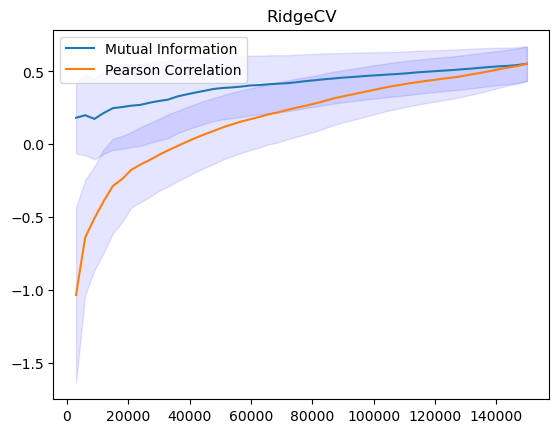

In [11]:
def plot_results(_plt, fun_name):
    columns = np.load(r"./ABIDE_predict_age/ABIDE_columns.npy")
    ABIDE_age_MI_foo = np.load(
        r"./ABIDE_predict_age/ABIDE_age_MI_{fun_name}.npy".format(
            fun_name=fun_name))
    ABIDE_age_Pearson_foo = np.load(
        r"./ABIDE_predict_age/ABIDE_age_Pearson_{fun_name}.npy".format(
            fun_name=fun_name))
    num_attr = np.around(np.linspace(
        0, len(columns), 10 + 1)[1:])  # ADJUST this based on actual settings

    MI_RidgeCV_mean = np.mean(ABIDE_age_MI_foo, 1)
    MI_RidgeCV_std = np.std(ABIDE_age_MI_foo, 1)
    Pearson_RidgeCV_mean = np.mean(ABIDE_age_Pearson_foo, 1)
    Pearson_RidgeCV_std = np.std(ABIDE_age_Pearson_foo, 1)

    _plt.plot(num_attr, MI_RidgeCV_mean, label="Mutual Information")
    _plt.fill_between(num_attr,
                      (MI_RidgeCV_mean + MI_RidgeCV_std * norm.ppf(0.025)),
                      (MI_RidgeCV_mean + MI_RidgeCV_std * norm.ppf(0.975)),
                      color='b',
                      alpha=.1)
    _plt.plot(num_attr, Pearson_RidgeCV_mean, label="Pearson Correlation")
    _plt.fill_between(
        num_attr,
        (Pearson_RidgeCV_mean + Pearson_RidgeCV_std * norm.ppf(0.025)),
        (Pearson_RidgeCV_mean + Pearson_RidgeCV_std * norm.ppf(0.975)),
        color='b',
        alpha=.1)
    _plt.title(fun_name)


plot_results(plt, "RidgeCV")